In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
# %matplotlib notebook

%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

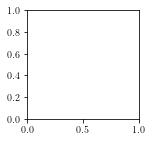

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [8]:
7 // 2

3

do_calculate_ecoli_Petsc4n



do_calculate_ecoli_Petsc4nPsi


True

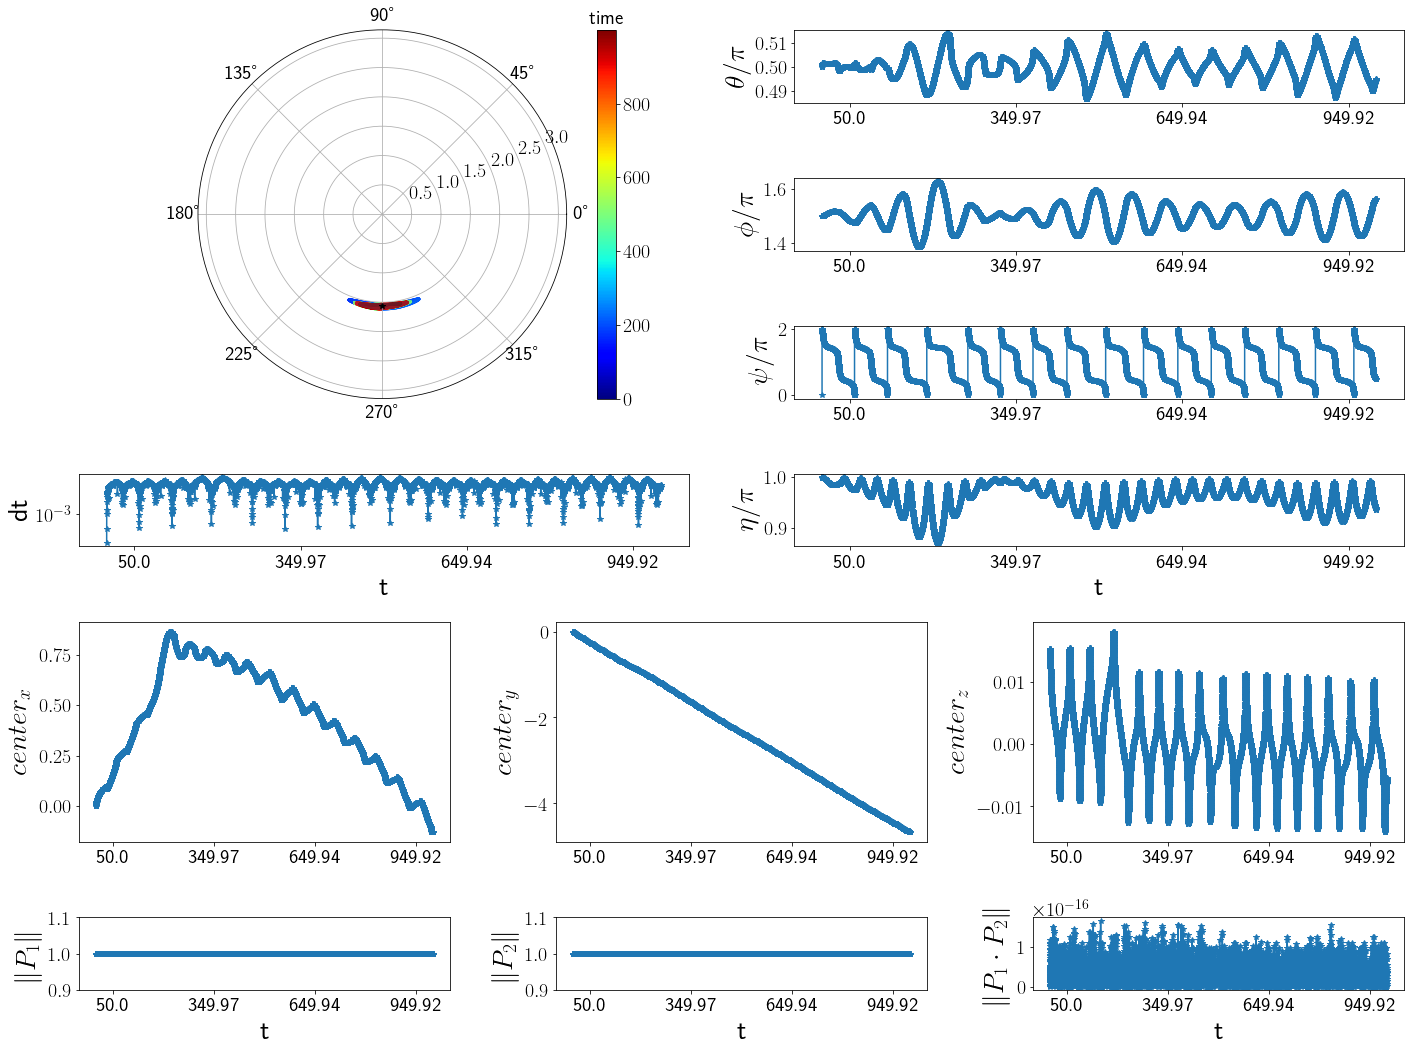

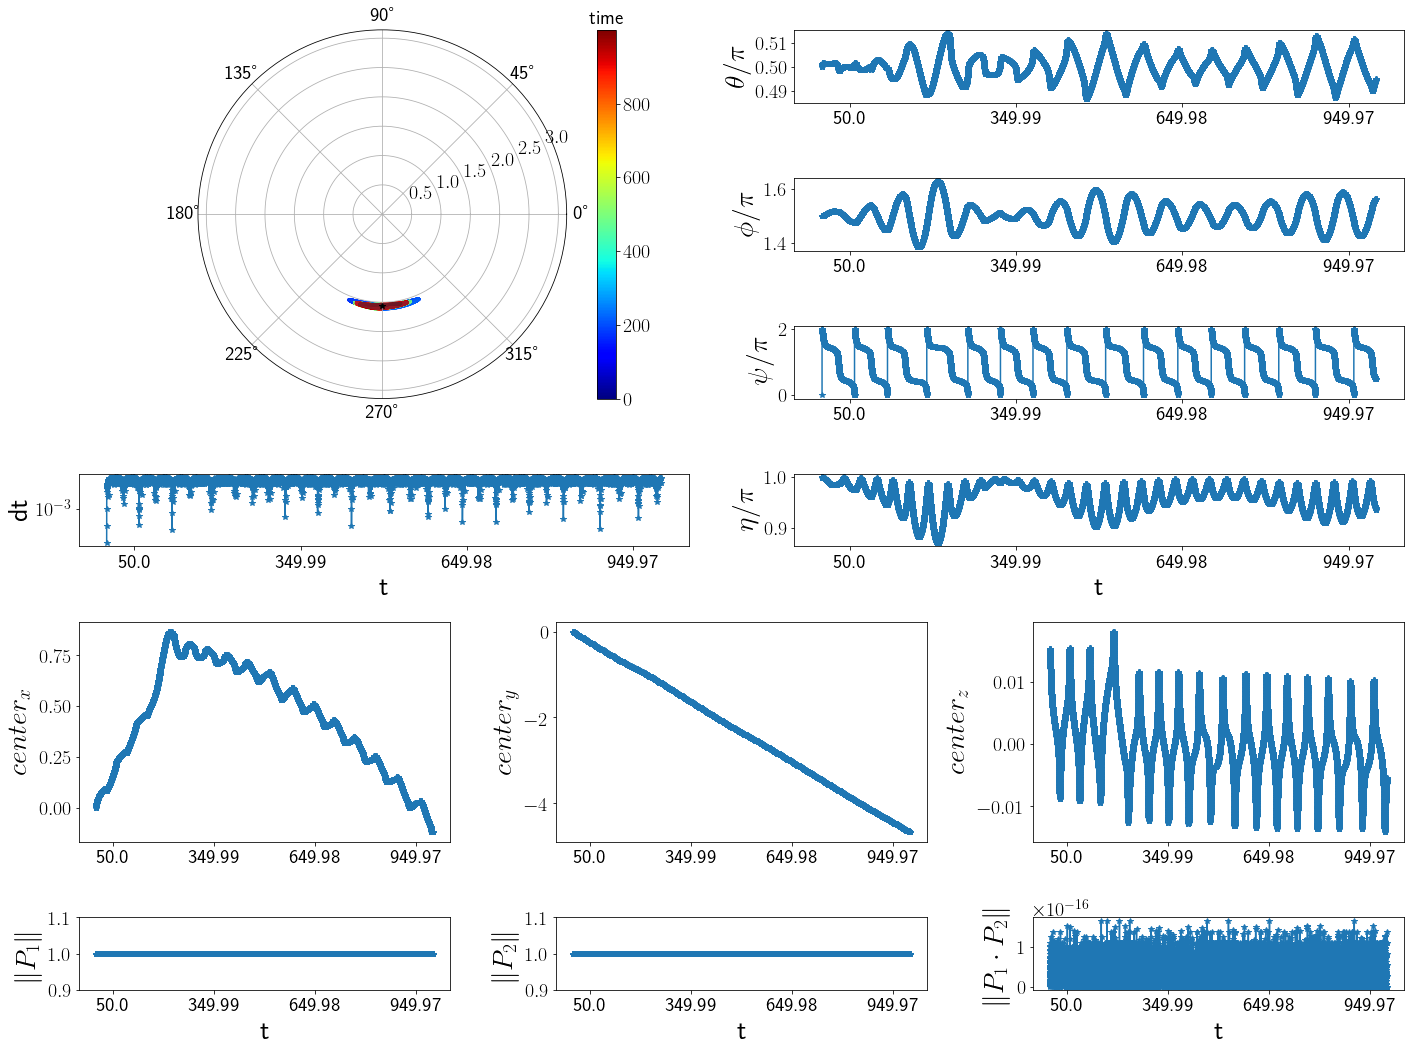

In [287]:
# active ecoli petsc family method 
importlib.reload(spf_tb)
importlib.reload(jm)

t0 = time()
t_theta, t_phi, t_psi = np.array((0.5, 1.5, 0)) * np.pi
update_fun='5bs'
rtol=1e-12
atol=1e-15
eval_dt = 1e-5
max_t = 1000
save_every = 1
table_name='ecoC01B05_tao1_wm0.75'
omega_tail=0.75

tnorm = np.array((np.sin(t_theta) * np.cos(t_phi), np.sin(t_theta) * np.sin(t_phi), np.cos(t_theta)))
t_psi = np.ones(1) * t_psi

print('do_calculate_ecoli_Petsc4n')
ta = spf_tb.do_calculate_ecoli_Petsc4n(tnorm, t_psi, max_t, update_fun=update_fun, rtol=rtol, atol=atol, 
                                          eval_dt=eval_dt, save_every=save_every, 
                                          table_name=table_name, omega_tail=omega_tail)
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta = ta
spf_tb.show_table_result(Table_t, Table_dt, Table_X, Table_P, Table_P2, 
                         Table_theta, Table_phi, Table_psi, Table_eta, save_every)

print('do_calculate_ecoli_Petsc4nPsi')
tb = spf_tb.do_calculate_ecoli_Petsc4nPsi(tnorm, t_psi, max_t, update_fun=update_fun, rtol=rtol, atol=atol, 
                                          eval_dt=eval_dt, save_every=save_every, 
                                          table_name=table_name, omega_tail=omega_tail)
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta = tb
spf_tb.show_table_result(Table_t, Table_dt, Table_X, Table_P, Table_P2, 
                         Table_theta, Table_phi, Table_psi, Table_eta, save_every)

# print(np.max(np.abs((ta[5] - tb[5], ta[6] - tb[6], ta[7] - tb[7]))))
# print(ta[5])
# print(tb[5])
# print(ta[6])
# print(tb[6])
# print(ta[7])
# print(tb[7])
# print(ta[3])
# print(tb[3])


In [278]:
from scipy.spatial.transform import Rotation as spR
tq = Quaternion()
def theta_phi_psi(P20, P, P2):
    t_theta = np.arccos(P[2] / np.linalg.norm(P))
    t_phi = np.arctan2(P[1], P[0])
    tfct = 2 if t_phi < 0 else 0
    t_phi = t_phi + tfct * np.pi  # (-pi,pi) -> (0, 2pi)
    # rotate the lateral norm back (the direction that norm=(0, 0, 1),
    #   and compare with ini lateral norm to calculate psi.
    tP = vector_rotation_norm(P2, norm=np.array((0, 0, 1)), theta=-t_phi)
    tP = vector_rotation_norm(tP, norm=np.array((0, 1, 0)), theta=-t_theta)
    sign = np.sign(np.dot(np.array((0, 0, 1)), np.cross(P20, tP)))
    t_psi = sign * np.arccos(np.clip(np.dot(tP, P20) / np.linalg.norm(tP)
                                     / np.linalg.norm(P20), -1, 1))
    tfct = 2 if t_psi < 0 else 0
    t_psi = t_psi + tfct * np.pi  # (-pi,pi) -> (0, 2pi)
    return t_theta, t_phi, t_psi

P = np.array((0, 0, 1))
# P = np.random.sample(3)
tlateral_norm = np.array((np.pi, np.e, np.euler_gamma))
tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
tlateral_norm = tlateral_norm - P * np.dot(P, tlateral_norm)
P2 = tlateral_norm / np.linalg.norm(tlateral_norm)
e0 = np.vstack((np.cross(P2, P), P2, P)).T
tq1 = spR.from_dcm(e0).as_quat()
tq.set_wxyz(tq1[3], tq1[0], tq1[1], tq1[2])

omega = np.array((1, 0, 0))
wt = 1
eval_n = 1000000
eval_dt = 1 / eval_n

R = tq.get_R()
P = R[:, 2]
P2 = R[:, 1]
tP = vector_rotation_norm(P2, norm=np.array((0, 0, 1)), theta=-phi0)
tP = vector_rotation_norm(tP, norm=np.array((0, 1, 0)), theta=-theta0)
P20 = tP / np.linalg.norm(tP)

# Petsc4n version, 1fe
tq_2 = Quaternion()
tq_2.set_wxyz(*tq.q)
for _ in range(eval_n):
    tP = tq_2.get_R()[:, 2]
    Wt = omega + wt * tP
    dQ = 0.5 * Wt.dot(tq_2.get_E())
    tq_2 = tq_2 + dQ * eval_dt
    tq_2.normalize()
R_2 = tq_2.get_R()
P_2 = R_2[:, 2]
P2_2 = R_2[:, 1]
print(theta_phi_psi(P20, P_2, P2_2))

# Petsc4nPsi version, 1fe
tq_2 = Quaternion()
tq_2.set_wxyz(*tq.q)
for _ in range(eval_n):
    dQ = 0.5 * omega.dot(tq_2.get_E())
    tq_2 = tq_2 + dQ * eval_dt
    tq_2.normalize()
R_2 = tq_2.get_R()
P_2 = R_2[:, 2]
P2_2 = R_2[:, 1]
print(theta_phi_psi(P20, P_2, P2_2))

(0.999999999999529, 4.7123895745822235, 2.5707960057483423)
(0.9999999999997099, 4.712388980384742, 1.5707963267943559)


In [211]:
4.71238898038469 / 3.1415

1.5000442401351868

In [198]:
import math
import numpy as np
import quaternion
from numpy import *

Q1 = Quaternion()
Q1.set_wxyz(*np.random.sample(4))
Q1.normalize()
omega = np.random.sample(3)

Q2 = quaternion.quaternion(*Q1.q)
dQ1 = 0.5 * omega.dot(Q1.get_E())
dQ2 = quaternion.quaternion(*omega) * Q2 / 2
Q3 = Quaternion()
Q3.set_wxyz(0, *omega / 2)
dQ3 = Q3.mul(Q1)
print(Q1)
print(Q2)
print(dQ1)
print(dQ2)
print(dQ3)

[0.27025 0.57517 0.76121 0.12921]
quaternion(0.270245712781903, 0.575173328957607, 0.761214907600564, 0.12920820726831)
[-0.45181  0.03266  0.15338 -0.10399]
quaternion(-0.451812911939085, 0.0326568682267627, 0.153377157518148, -0.103985932879523)
[-0.45181  0.03266  0.15338 -0.10399]
